In [33]:
import urllib3
import json
import requests
import pandas as pd
from ggplot import *
import datetime
import seaborn as sns

import matplotlib as plt

%matplotlib inline


In [61]:
apikey = open('wu_api.txt').readlines()[0]
forecast_URL='http://api.wunderground.com/api/' + apikey + '/hourly/q/CA/San_Francisco.json'
yesterday_URL='http://api.wunderground.com/api/' + apikey + '/yesterday/q/CA/San_Francisco.json'

forecast_data = requests.get(forecast_URL).json()
yesterday_data = requests.get(yesterday_URL).json()



In [62]:
forecast = pd.DataFrame.from_dict(forecast_data['hourly_forecast'])

#Convert Dictionary to Dataframe and grab only relevant columns
forecast = forecast[['FCTTIME','temp']]
forecast['hour'] = forecast.FCTTIME.apply(lambda x: x.get('hour'))
forecast['day'] = forecast.FCTTIME.apply(lambda x: x.get('mday'))
forecast['temp']= forecast.temp.apply(lambda x: x.get('english'))
forecast.drop(['FCTTIME'], inplace=True, axis=1)

#Get data for today
now = datetime.datetime.now()
forecast = forecast[forecast['day'] == str(now.day) ]
forecast = forecast.apply(pd.to_numeric)

#print((forecast['hour'] == 23).any())

#for i in range(0,24):
#    if (forecast['hour'] == i).any():
#        forecast = forecast.append(pd.DataFrame({'hour': i, 'day': now.day, 'temp':0}, index=[0]), ignore_index=True)

print(forecast)

   temp  hour  day
0    64    14   28
1    65    15   28
2    66    16   28
3    64    17   28
4    63    18   28
5    62    19   28
6    60    20   28
7    59    21   28
8    58    22   28
9    57    23   28


In [63]:
#yesterday = yesterday_data['history']['observations']
yesterday = pd.DataFrame.from_dict(yesterday)

#Convert Dictionary to Dataframe and grab only relevant columns
yesterday = yesterday[['date','tempi']]
yesterday['hour'] = yesterday.date.apply(lambda x: x.get('hour'))
yesterday['day'] = yesterday.date.apply(lambda x: x.get('mday'))
yesterday['temp']= yesterday.tempi
yesterday.drop(['date', 'tempi'], inplace=True, axis=1)

#Remove missing data??
yesterday = yesterday[yesterday.temp != '-9999']

{'response': {'version': '0.1', 'termsofService': 'http://www.wunderground.com/weather/api/d/terms.html', 'features': {'yesterday': 1}}, 'history': {'date': {'pretty': 'July 27, 2017', 'year': '2017', 'mon': '07', 'mday': '27', 'hour': '12', 'min': '00', 'tzname': 'America/Los_Angeles'}, 'utcdate': {'pretty': 'July 27, 2017', 'year': '2017', 'mon': '07', 'mday': '27', 'hour': '19', 'min': '00', 'tzname': 'UTC'}, 'observations': [{'date': {'pretty': '12:56 AM PDT on July 27, 2017', 'year': '2017', 'mon': '07', 'mday': '27', 'hour': '00', 'min': '56', 'tzname': 'America/Los_Angeles'}, 'utcdate': {'pretty': '7:56 AM GMT on July 27, 2017', 'year': '2017', 'mon': '07', 'mday': '27', 'hour': '07', 'min': '56', 'tzname': 'UTC'}, 'tempm': '15.0', 'tempi': '59.0', 'dewptm': '11.7', 'dewpti': '53.1', 'hum': '81', 'wspdm': '18.5', 'wspdi': '11.5', 'wgustm': '-9999.0', 'wgusti': '-9999.0', 'wdird': '290', 'wdire': 'WNW', 'vism': '16.1', 'visi': '10.0', 'pressurem': '1015.9', 'pressurei': '30.00', 

KeyError: "['date' 'tempi'] not in index"

In [57]:
#Combine Data Frame
alldata = [yesterday, forecast]
alldata = pd.concat(alldata)

alldata = alldata.apply(pd.to_numeric)
alldata['subject'] = 0

alldata = alldata.drop_duplicates()
print(alldata)

    day  hour  temp  subject
0    27     0  59.0        0
1    27     1  60.1        0
2    27     2  59.0        0
3    27     3  60.1        0
4    27     4  57.9        0
5    27     5  57.9        0
7    27     6  57.0        0
8    27     7  57.0        0
10   27     8  60.1        0
11   27     9  60.1        0
12   27    10  63.0        0
13   27    11  66.0        0
14   27    12  66.0        0
15   27    13  66.9        0
16   27    14  75.9        0
17   27    15  70.0        0
18   27    16  68.0        0
19   27    17  66.0        0
20   27    18  64.9        0
21   27    19  63.0        0
22   27    20  60.1        0
23   27    21  61.0        0
24   27    22  60.1        0
25   27    23  59.0        0
0    28    13  63.0        0
1    28    14  64.0        0
2    28    15  64.0        0
3    28    16  66.0        0
4    28    17  64.0        0
5    28    18  63.0        0
6    28    19  62.0        0
7    28    20  60.0        0
8    28    21  59.0        0
9    28    22 

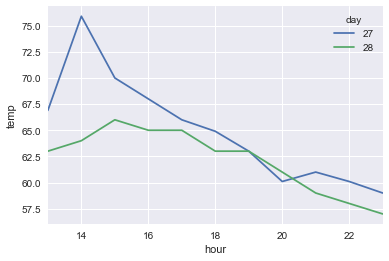

In [30]:
tempplot = sns.tsplot(data=alldata, time='hour', condition='day', value='temp', unit='subject')


(11, 3)
(25, 3)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

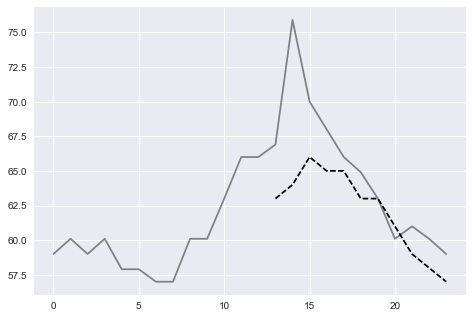

In [36]:
print(forecast.shape)
print(yesterday.shape)
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(yesterday.hour, yesterday.temp, 'gray')
ax.plot(forecast.hour, forecast.temp, 'black', ls="--")

ax.fill_between(yesterday.hour, forecast.temp, yesterday.temp)

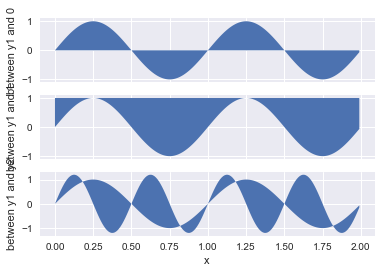

In [35]:

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0.0, 2, 0.01)
y1 = np.sin(2*np.pi*x)
y2 = 1.2*np.sin(4*np.pi*x)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.fill_between(x, 0, y1)
ax1.set_ylabel('between y1 and 0')

ax2.fill_between(x, y1, 1)
ax2.set_ylabel('between y1 and 1')

ax3.fill_between(x, y1, y2)
ax3.set_ylabel('between y1 and y2')
ax3.set_xlabel('x')
